In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

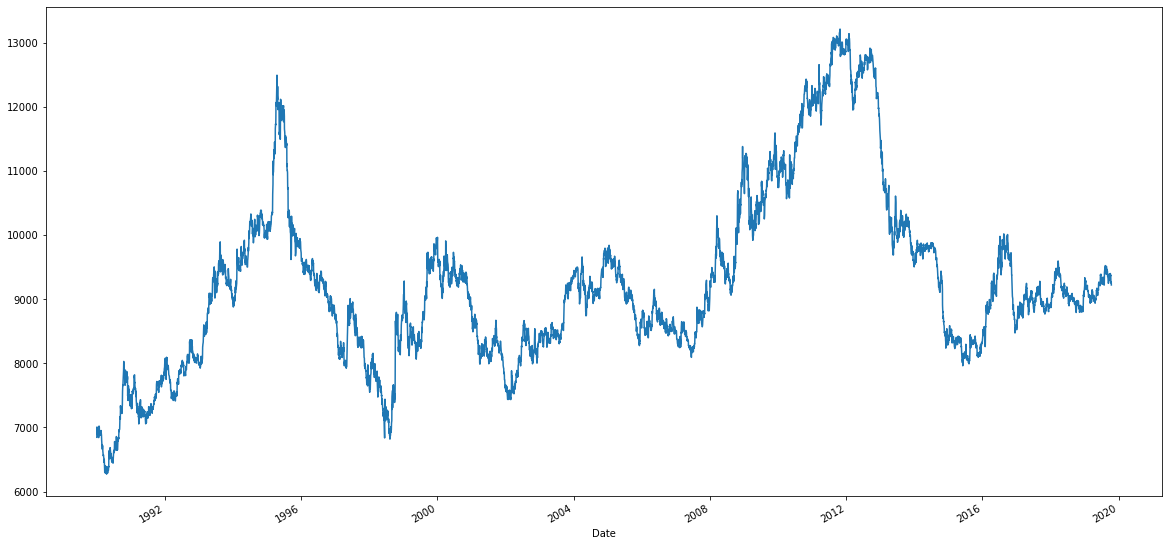

In [5]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!

yen_futures.Settle.plot(figsize=(20,10))

**JOHN'S ANALYSIS**:
The yen seems to trend upwards in the period between 1990-1996. It peaks in 1996 at what looks like close to 12,750, but then drops in year 1998 at 6,900 mark. There'a a lot of spikiness to the data. If you notice at what I assume is the 1998 point on the x-axis, there looks to be two drops. So it looked like it dropped in early 1998 below 7,000, then quickly spiked up that year, and dropped again later in the year below 7,000. Gradually the yen settle price trends upwards after 2,000 with gradual small declines between years 2000-2008 staying within or below 10,000, and sharply increases in 2010 to peak at the maximum 13,000 in 2012-2016 time interval, and sharply declines agin by 2015-2016. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])               # Hodrick-Prescott separates a time-series into trend, and non-trend (noise) components. 
                                                                                          # Tells us how far-off our time series data is actually from the trend/cycle element. 

<AxesSubplot:xlabel='Date'>

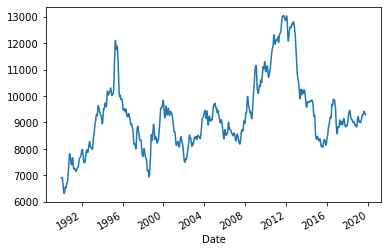

In [7]:
# Plotting the yen Settle price trend.
settle_trend.plot()

<AxesSubplot:xlabel='Date'>

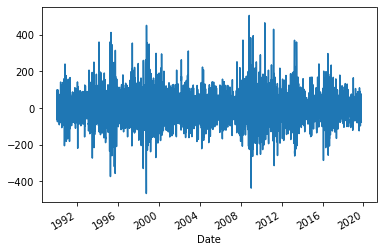

In [8]:
# Plotting the yn Settle price noise.
settle_noise.plot()

In [9]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

decomposition_yen_settle = pd.DataFrame(
    columns = ['Settle', 'noise', 'trend']
)

decomposition_yen_settle['Settle'] = yen_futures['Settle']
decomposition_yen_settle['noise'] = settle_noise
decomposition_yen_settle['trend'] = settle_trend

decomposition_yen_settle.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='Date'>

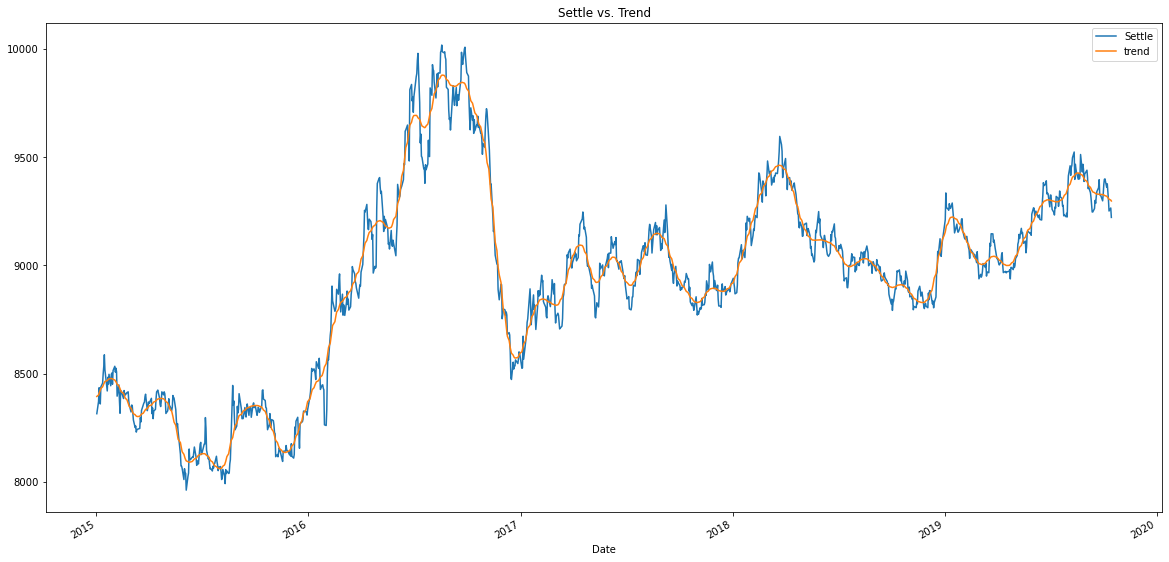

In [10]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
decomposition_yen_settle[['Settle', 'trend']]['2015':].plot(title='Settle vs. Trend', figsize=(20,10))

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

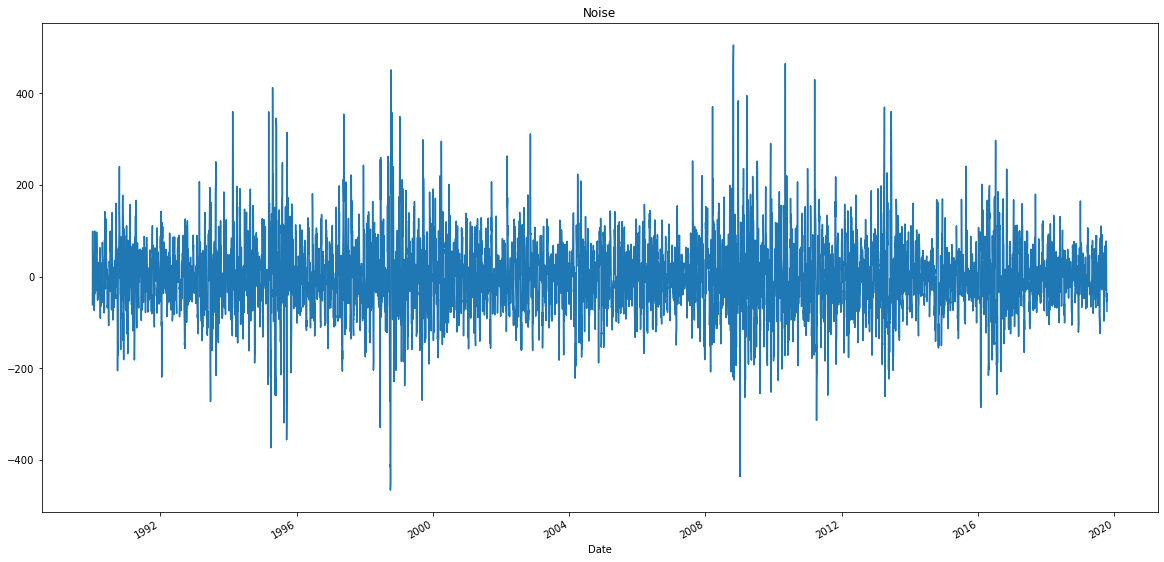

In [11]:
# Plot the Settle Noise
# YOUR CODE HERE!
decomposition_yen_settle.noise.plot(title='Noise', figsize=(20,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


### Testing for Stationarity of the DATA for our ARMA Model

<AxesSubplot:xlabel='Date'>

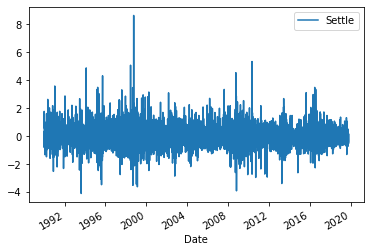

In [13]:
# CODER's NOTE: ARMA models require Stationarity in the data in order to generate an ARMA.
# The code already runs a .pct_change() on the returns data, so it should be Stationary for an ARMA model to accept.
returns.plot()                      # the plot looks like the returns data is Stationarity.           

In [14]:
# Run an Augemented Dickey-Fuller test to determine confidence of Stationarity. 
from statsmodels.tsa.stattools import adfuller 
adfuller(returns.Settle)

(-87.67736238539432,
 0.0,
 0,
 7513,
 {'1%': -3.4312206955500963,
  '5%': -2.8619247816139843,
  '10%': -2.5669748148389813},
 15724.766827334091)

**JOHN'S ANALYSIS: Is the data stationary?** \
YES. From both the shape of our plot and Augmented Dickey-Fuller test. The returns data we have is **Stationary**. The plot graph of Settle value percent changes does not indicate a trend. Most of the values clusters around zero. The **ADF score** is strongly **negative** at **-87.68** so we can be very confident that the Settle values in our returns dataset is **random**, with no unit root acting on the data to pull it towards any trend. The **p-value** is perfectly **zero**. Nevertheless, we can proceed to use this data to construct our ARMA and ARIMA models. 

### Build and Fit the ARMA Model

In [27]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

from statsmodels.tsa.arima_model import ARMA                                      # import the ARMA library to be build ARMA models. 
import warnings                                                                   # import warnings to avoid warning messages generated by these complex model libraries. 
warnings.filterwarnings('ignore')                                                 


model = ARMA(returns.values, order=(2, 1))                                        # build the model variable, pass array of returns.
                                                                                  # pass a tuple to denote lag-terms orders for (Auto-Regrassion AR, Moving Average MA)

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!

# CODER' NOTE: Code originally failed. It thinks the time-series is not Not-Stationary. It will not fit the model variable. Returned Non-Stationary error.
# But the time-series is Stationary, we checked it above before making our ARMA model. Very negative ADF score, very low p-value. 

results = model.fit(start_ar_lags = 4)                                           # in order to fix the problem, I specified the number of AR lags manually. I guess it's the data.

In [28]:
# Output model summary results:
# YOUR CODE HERE!

results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 11 May 2021   AIC                          15798.142
Time:                        22:39:22   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2948      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3337           +0.0000j            3.3337            0.5000
AR.2         -157.1449           +0.0000j          157.1449            0.5000
MA.1           -3.3925           +0.0000j            3.3925            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5-Day Returns Forecast'}>

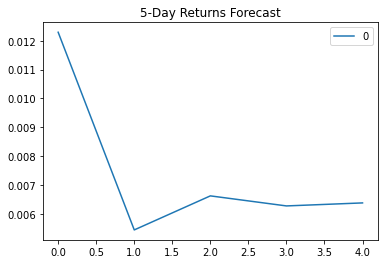

In [29]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!

forecast_results = results.forecast(steps=5)                 # define a variable for forecast results, seting 5 as our steps.
forecast_df = pd.DataFrame(                                  # put the forecast results into a DataFrame
    forecast_results[0]                                      # we set the 0 poistion
)
forecast_df.plot(title='5-Day Returns Forecast')

**JOHN'S ANALYSIS: How good is our ARMA model?** 

* Looking at the graph output on the interbal of the 5 days out. It seems the next 5 days the value of the yen plummets within a day from .012, or 1.2 to .005, a loss of 58.33% within 1 day. But gradually regains close to 30% of it's value back hovering at about .0065 on average. The yen is only 54% of what it was 4 days ago.  

* The number of datapoints used for this model was 7514 according to the summary.
* The AIC and BIC measurements are closely similar in value, 15,798 and 15,832, only a difference of 35 points.
* We want AIC and BIC to be strongly negative, and have correlated values. 
* The p-values for our coefficents being entered are nearing 1. Very high p-values (.8, .9). Not a good sign our model is fitted good.
* The standard errors are over 1.0 for some coefficient inputs. We want this at zero.

* **CONCLUSION:** Our ARMA model is not fitted with enough data. We would need to add in more datapoints. 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [33]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

model_2 = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
# YOUR CODE HERE!

results_2 = model_2.fit(start_ar_lags = 10)                            # Manually inputted Auto Regression lags to get ARIMA model variable to fit. Used a high number to get code to work.

In [34]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 11 May 2021   AIC                          83905.238
Time:                        23:15:11   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3786j            2.3408           -0.1002
AR.2            1.8918           +1.3786j            2.3408            0.1002
AR.3           -2.2703           -3.0204j            3.7785           -0.3526
AR.4           -2.2703           +3.0204j            3.7785            0.3526
AR.5          -11.0792           -0.0000j           11.0792           -0.5000
MA.1            3.3641           +0.0000j            3.3641            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5-Day Returns Forecast'}>

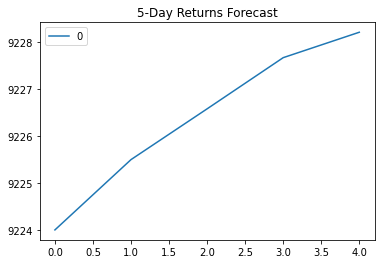

In [35]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
forecast_results_2 = results_2.forecast(steps=5)               # define a variable for forecast results, seting 5 as our steps.
forecast_df_2 = pd.DataFrame(                                  # put the forecast results into a DataFrame
    forecast_results_2[0]                                      # we set the 0 poistion
)
forecast_df_2.plot(title='5-Day Returns Forecast')

**JOHN'S ANALYSIS: ARIMA Model Findings**
* Over the next 4 days we see a smooth increase in the value of the yen. In our ARMA model we saw a sharp decline, but then a consistent increase over the remaining 4 days. It will be a 4.3% increase in value. 
* AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) values are similar in values, 55 value difference. 
* The p-values for our AR regression lags are stilll high, .6, .9, the lowest being .3. But we want to see these values closer to zero and ideally no more than .01.
* The std errors for our inputted coefficients are below 1.0. We want these values to be close to zero, most of them are.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [36]:
import arch 

In [38]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model_3 = arch.arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
# YOUR CODE HERE!
results_3 = model_3.fit(disp='off')

In [39]:
# Summarize the model results
# YOUR CODE HERE!
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, May 11 2021   Df Residuals:                     7510
Time:                        23:47:22   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [40]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [41]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts_garch = results_3.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts_garch

In [43]:
# Annualize the forecast
intermediate = np.sqrt(forecasts_garch.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [45]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

# Each row in the DataFrame repesents the forecasted volatility starting from 10-15-2019. 
# h.1 is 10-16-2019, h.2 is 10-17-2019, etc.
# Increased volatility.

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:title={'center':'5-Day Forecasr of Volatility'}>

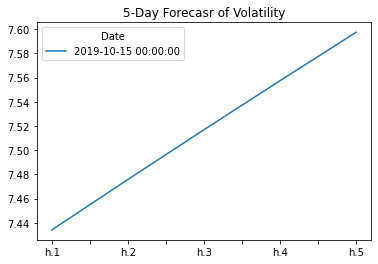

In [47]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title='5-Day Forecasr of Volatility')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

**JOHN'S ANALYSIS:**

**YES.** Buy YEN based on the data provided, but **short-term**. But do not hold longer than a year or two. In my opinion this a clear "BUY THE DIP" scenario. We saw in our ARMA model, a big decline, followed by gradual increase over time, which is confirmed with our ARIMA results. And our GARCH model we saw for each day of value increase, and increase in volatility. With more volatility comes with a greater return. But this based on the data we used to run we these models. And our **SETTLE VS TREND** plotting showed many micro-instances of sharp declines, increases. While the yen is rising in our model, volatility is rising and we can expect a sudden sharp decline again. **I would buy YEN now and hold short-term, maybe do not hold it longer than a year.**

As for the reliability of our model. I do not see it to be underfitted, but it is not ideal. We're not learning much about the behavior of the yen with only 5-days of results. We saw in our **SETTLE VS TREND** decomposition that while the datapoints do not deviate from the trend (*the orange line*), the value of the yen is prone to sudden sharp decreases, followed by steady increases, all within a period of a year. Not taking into account any other outside factors that could affect these random trends. I would think we need to fit this model with more data before making an official investment decision.